#### Load Packages

In [1]:
# importing packages
import pandas as pd
import numpy as np
import pprint
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
AcquisitionColumnNames = (
    "LOAN_ID", "ORIG_CHN", "Seller.Name", 
    "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE",
    "FRST_DTE", "OLTV", "OCLTV", "NUM_BO", 
    "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", 
    "PROP_TYP", "NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", 
    "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", 
    "RELOCATION_FLG"
)

PerformanceColumnNames = (
    "LOAN_ID", "Monthly.Rpt.Prd", "Servicer.Name", 
    "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat", 
    "Adj.Month.To.Mat", "Maturity.Date", "MSA", 
    "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
    "ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", 
    "FCC_COST", "PP_COST", "AR_COST", "IE_COST", 
    "TAX_COST", "NS_PROCS","CE_PROCS", "RMW_PROCS", 
    "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", 
    "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"
)

In [3]:
acquisition_df = pd.read_csv("Acquisition_2010Q1.txt",
                            names = AcquisitionColumnNames,
                            header = None, sep = '|')

performance_df = pd.read_csv("Performance_2010Q1.txt",
                             names = PerformanceColumnNames,
                             header = None, sep = '|')

C:\Users\gaura\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Data Modification

In [4]:
DS = set(performance_df['Delq.Status'])

In [5]:
print(DS)

mapper = {}
for ds in DS:
    try:
        mapper[ds] = int(ds)
    except:
        mapper[ds] = -1

performance_df['Delq.Status'] = performance_df['Delq.Status'].map(mapper)

{nan, '30', '1', '20', '13', '7', '77', '40', '11', '14', '35', '89', '90', '32', '66', '8', '41', '69', '97', '0', '88', '24', '42', '58', '61', '75', '56', '46', '63', '52', '3', '81', '33', '65', '28', '34', '50', '95', '60', '5', '39', '57', '82', '68', '22', '47', '27', '99', '72', '71', '23', '29', '59', '70', '78', '54', '12', '79', 'X', '15', '26', '43', '84', '86', '37', '96', '83', '38', '87', '62', '80', '19', '17', '45', '64', '85', '94', '76', '36', '91', '25', '49', '31', '10', '92', '93', '98', '16', '74', '21', '6', '2', '73', '4', '55', '53', '51', '44', '48', '67', '18', '9'}


#### Grouping By Loan ID

In [6]:
loans=performance_df.groupby("LOAN_ID", sort=True)['Delq.Status'].max()

ID_To_Delinq = {}

for row in loans.iteritems():
    loan_id, delinq = row
    ID_To_Delinq[loan_id] = delinq

In [7]:
def mapper(row):
    return ID_To_Delinq.get(row['LOAN_ID'], -1)

acquisition_df['MAX_DELINQ'] = acquisition_df.apply(mapper,axis=1)

In [8]:
DEL_NOTNAN = acquisition_df["MAX_DELINQ"].notna()
df = acquisition_df[DEL_NOTNAN]
DEL_NOTNEG = df['MAX_DELINQ'] >= 0
df = df[DEL_NOTNEG]
OLTV = df['OLTV'].notna()
df = df[OLTV]
CS = df['CSCORE_B'].notna()
df = df[CS]

def mapper(row):
    delinq = row['MAX_DELINQ']
    if delinq > 12:
        return 2
    elif delinq > 0:
        return 1
    if delinq == -1:
        return -1
    else:
        return 0

df['Delinq.Bin'] = df.apply(mapper, axis=1)

credit_score  = np.array(df['CSCORE_B'])
loan_to_value = np.array(df['OLTV'])
max_delinq    = np.array(df['Delinq.Bin'])

X = np.array([credit_score, loan_to_value]).transpose()
y = np.array([max_delinq]).transpose()
print(X.shape)
print(y.shape)

Total = np.hstack([X, y])
print(Total.shape)
np.random.shuffle(Total)

X = Total[:, :2]
y = Total[:, 2:]

print(X.shape)
print(y.shape)

prop = 0.8
train_num = int(prop * len(Total))
print(f"Train Number: {train_num}")

X_train, X_test = X[:train_num], X[train_num:]
y_train, y_test = y[:train_num], y[train_num:]

print(f"X_Train: {X_train.shape}")
print(f"X_Test: {X_test.shape}")
print("=="*10)
print(f"y_Train: {y_train.shape}")
print(f"y_Test:  {y_test.shape}")

class_names = np.unique(y)

(322866, 2)
(322866, 1)
(322866, 3)
(322866, 2)
(322866, 1)
Train Number: 258292
X_Train: (258292, 2)
X_Test: (64574, 2)
y_Train: (258292, 1)
y_Test:  (64574, 1)


(array([293864.,      0.,      0.,      0.,      0.,  27421.,      0.,
             0.,      0.,   1581.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

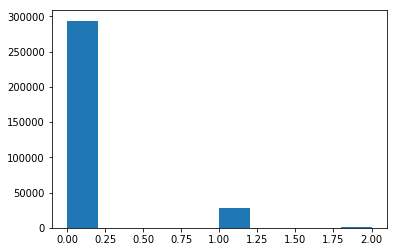

In [9]:
plt.hist(y)

#### Create Class Weighting

In [10]:

V, C = np.unique(y, return_counts=True)

class_weights = {}

for v, c in zip(V, C):
    prop = c / len(y)
    print(v, " | ", c)
    class_weights[v] = 1 - prop

0.0  |  293864
1.0  |  27421
2.0  |  1581


#### Create Class to Train, Test, and Store Results

In [32]:
class Test_Ml:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_train_reshape = y_train.reshape(y_train.shape[0],)
        self.y_test_reshape = y_test.reshape(y_test.shape[0],)
    
    def DTC(self):
        dtc = tree.DecisionTreeClassifier(max_depth = None, class_weight = class_weights).fit(self.X_train, self.y_train)
        dtc_pred = dtc.predict(self.X_test)
        cm = confusion_matrix(self.y_test, dtc_pred)
        score = dtc.score(self.X_test, self.y_test)
        return score, cm
    
    def RFC(self):
        rfc = RandomForestClassifier(n_estimators = 50, class_weight = class_weights).fit(self.X_train, self.y_train_reshape)
        rfc_pred = rfc.predict(self.X_test)
        cm = confusion_matrix(self.y_test_reshape, rfc_pred)
        score = rfc.score(self.X_test, self.y_test_reshape)
        return score, cm
    
    def SVM(self):
        svc = svm.SVC(gamma = 'scale', decision_function_shape = 'ovo', max_iter = 1500).fit(self.X_train, self.y_train_reshape)
        svc_pred = svc.predict(self.X_test)
        cm = confusion_matrix(self.y_test_reshape, svc_pred)
        score = svc.score(self.X_test, self.y_test_reshape)
        return score, cm
    
    def NN(self, batch_size = 64, shuffle_buffer_size = 100, epochs = 1):
        train_dataset = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))
        test_dataset = tf.data.Dataset.from_tensor_slices((self.X_test, self.y_test))
        
        train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
        test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
        
        output_size = len(np.unique(self.y_train))
        
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, input_shape = [2]),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(output_size, activation = 'softmax')
        ])
        
        model.compile(optimizer = tf.keras.optimizers.RMSprop(),
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
        
        history = model.fit(train_dataset, validation_data = test_dataset, class_weight = class_weights, epochs = epochs)
        
        nn_pred = model.predict_classes(self.X_test)
        
        score = np.mean(nn_pred == self.y_test)
        cm = confusion_matrix(self.y_test, nn_pred)
        return score, cm
    
    def Plot_Confusion_Matrix(self, cm):
        cm_mod = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        fig, ax = plt.subplots()
        im = ax.imshow(cm_mod, interpolation = 'nearest', cmap = plt.cm.Blues)
        ax.set(xticks = np.arange(cm_mod.shape[1]),
               yticks = np.arange(cm_mod.shape[0]),
               ylabel='True label',
               xlabel='Predicted label')
         
        fmt = '.2f'
        thresh = cm_mod.max() / 2.
        for i in range(cm_mod.shape[0]):
            for j in range(cm_mod.shape[1]):
                ax.text(j, i, format(cm_mod[i, j], fmt),
                        ha = 'center', va = 'center',
                        color = 'white' if cm_mod[i, j] > thresh else 'black')
            
        fig.tight_layout()

#### Testing Model

In [33]:
test_models = Test_Ml(X_train, X_test, y_train, y_test)

In [34]:
result = [test_models.DTC(), test_models.RFC(), test_models.SVM(), test_models.NN()]

C:\Users\gaura\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


4036/4036 [==============================] - 38s 10ms/step - loss: 1.3364 - sparse_categorical_accuracy: 0.9098 - val_loss: 1.4253 - val_sparse_categorical_accuracy: 0.9116


In [35]:
result_df = pd.DataFrame(result, index = ['DTC', 'RFC', 'SVM', 'NN'], columns = ['score', 'cm'])
print(result_df)

        score                                                 cm
DTC  0.680011  [[41222, 17301, 341], [2634, 2685, 70], [119, ...
RFC  0.725989  [[44496, 14250, 118], [2984, 2381, 24], [141, ...
SVM  0.824372  [[52014, 6850, 0], [4170, 1219, 0], [228, 93, 0]]
NN   0.911574         [[58864, 0, 0], [5389, 0, 0], [321, 0, 0]]


#### Results of Scoring

In [36]:
scores_dictionary = {'Decision Tree': result_df['score']['DTC'], 
                     'Random Forest': result_df['score']['RFC'], 
                     'Support Vector Machine': result_df['score']['SVM'], 
                     'Tensorflow Network': result_df['score']['NN']}

In [37]:
pprint.pprint(scores_dictionary)

{'Decision Tree': 0.680010530554093,
 'Random Forest': 0.7259887880571128,
 'Support Vector Machine': 0.8243720382816614,
 'Tensorflow Network': 0.9115743178369003}


#### Plot Confusion Matrix

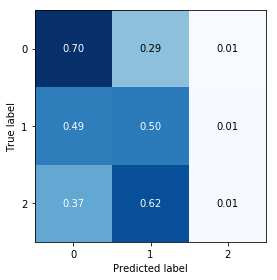

In [38]:
# Decision Tree
test_models.Plot_Confusion_Matrix(result_df['cm']['DTC'])

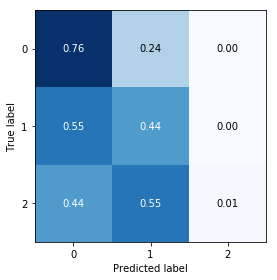

In [39]:
# Random Forest 
test_models.Plot_Confusion_Matrix(result_df['cm']['RFC'])

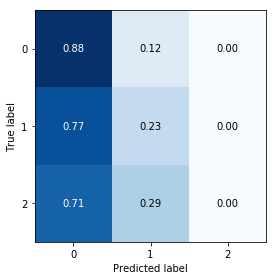

In [40]:
# Support Vector Machine
test_models.Plot_Confusion_Matrix(result_df['cm']['SVM'])

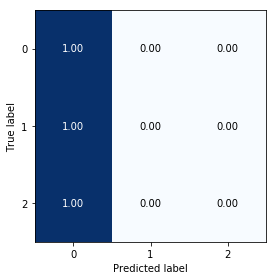

In [41]:
# Tensorflow Network
test_models.Plot_Confusion_Matrix(result_df['cm']['NN'])